In [1]:
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
# Loading the dataset;
db = pd.read_csv("../nested_CV/fold_2_test_set.csv")

# removing the id and the subtypes of a given dataset
def extract_PATIENT_INFO(db):
   ids =  db.pop("ID")
   morf_codificata = db.pop("morf_codificata")
   luogoTc= db.pop("luogoTC_codificato")
   return db, ids, morf_codificata, luogoTc

# extrating the label
y_test = db.pop("label")
X_test = db

In [2]:
from sklearn.metrics import confusion_matrix

def compute_sensitivity_specificity(y_true, y_pred):
    """
    Compute sensitivity and specificity from true labels and predictions.

    Parameters:
    y_true (list or array): True binary labels (0 or 1).
    y_pred (list or array): Predicted binary labels (0 or 1).

    Returns:
    dict: A dictionary with sensitivity and specificity.
    """
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return {"Sensitivity": round(sensitivity,3), "Specificity": round(specificity,3)}

## Binary Classification using all the classes

In [3]:
# Path of the saved pipeline on the local pc
path = "../Elements/Boruta_RusBoost/AcrossSplits/Split2_Boruta_RusBoostFitted_pipeline.pkl"

In [4]:
loaded_pipeline = joblib.load(path) # to load the model

In [5]:
X_test, ids_test, morf_codificata_test, luogoTc = extract_PATIENT_INFO(X_test) #to remove the patient infos

predictions = loaded_pipeline.predict(X_test)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1])

In [6]:
compute_sensitivity_specificity(y_test, predictions)

{'Sensitivity': 0.905, 'Specificity': 0.934}

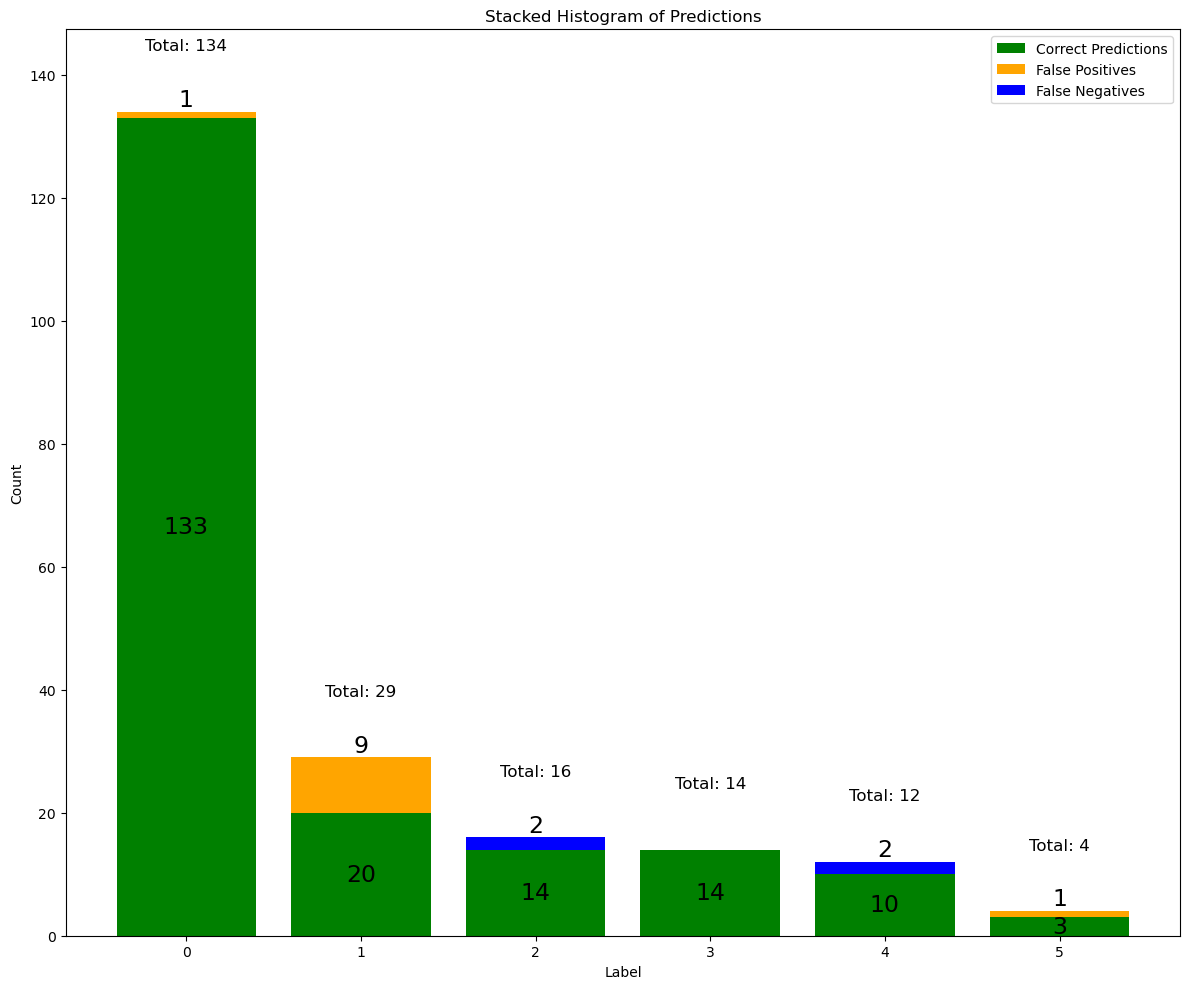

In [7]:
from Components import ErrorAnalysis
ErrorAnalysis.StackedHist(predictions=predictions, y_test=y_test, morf_codificata_test=morf_codificata_test)

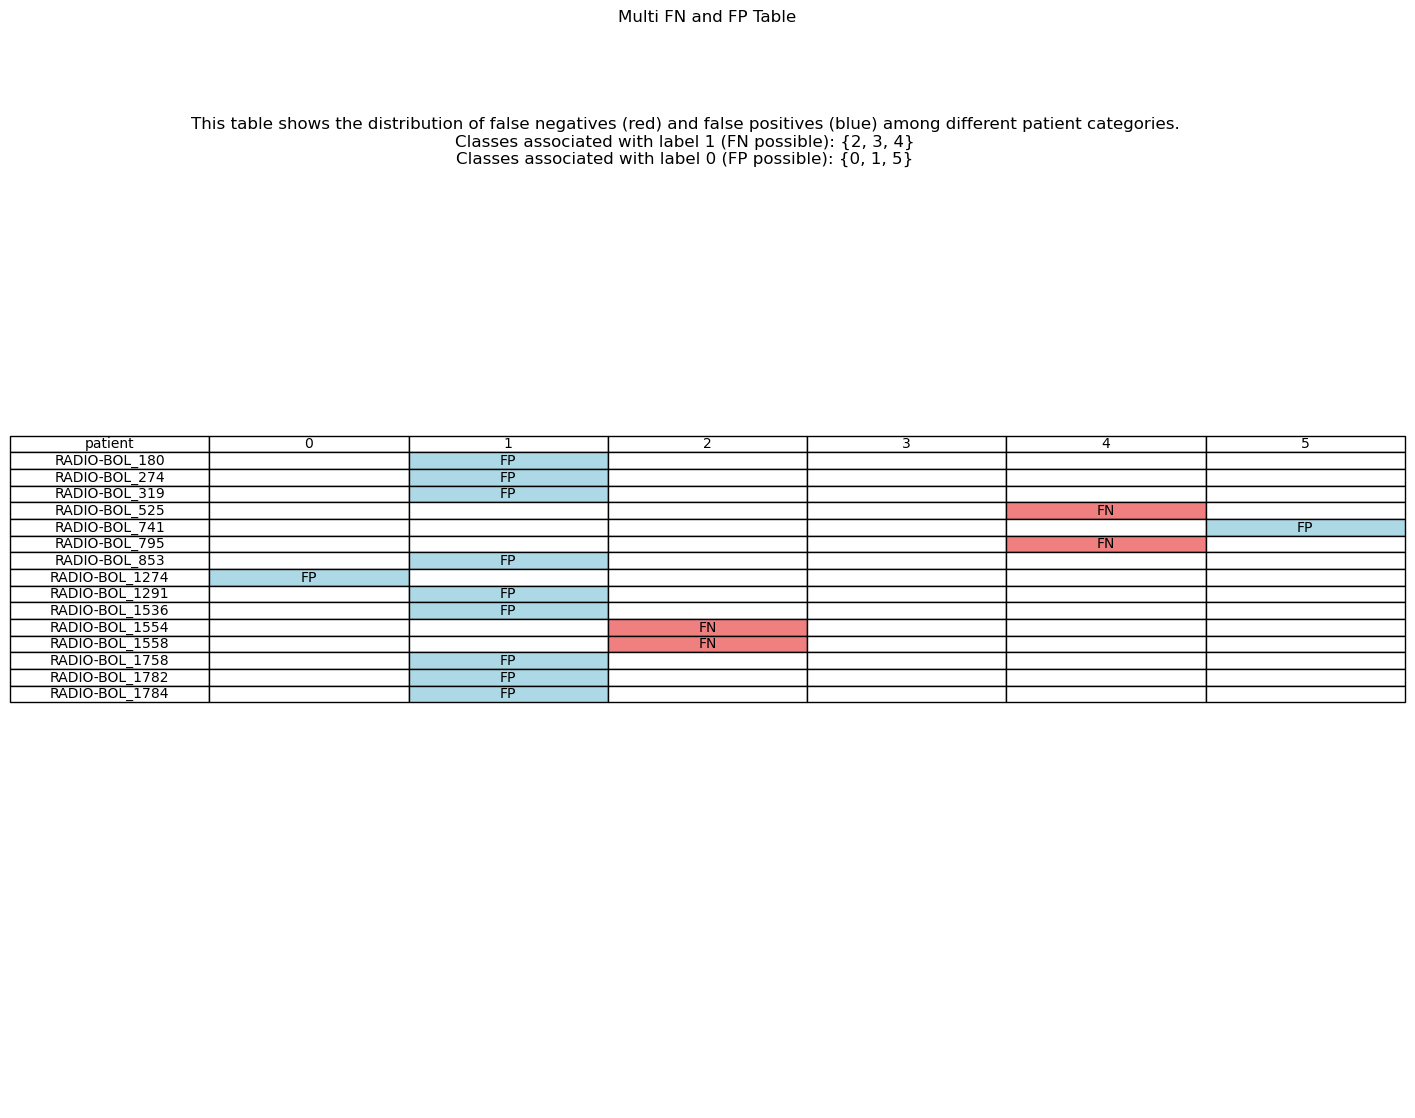

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def TableSubTypesErrors(morf_codificata, FoundFN_IDs, FoundFP_IDs, ids, size):
    # Create a DataFrame for the combined table
    unique_values = morf_codificata.unique()
    sorted_ids_errors = sorted(FoundFN_IDs + FoundFP_IDs, key=lambda x: int(x.split('_')[1]))
    table_df = pd.DataFrame({'patient': sorted_ids_errors})

    # Add columns for each unique value in morf_codificata and initialize with empty strings
    for value in sorted(map(int, unique_values)):
        table_df[value] = ''

    # Populate the DataFrame with 'x' for FN and FP with color labels
    for patient in FoundFN_IDs:
        if patient in ids.values:
            morf_value = morf_codificata[ids == patient].values[0]
            if morf_value in unique_values:
                table_df.loc[table_df['patient'] == patient, morf_value] = 'FN'
            else:
                print("There is a problem with FN!")
        else:
            print("Patient not found in FN IDs!")

    for patient in FoundFP_IDs:
        if patient in ids.values:
            morf_value = morf_codificata[ids == patient].values[0]
            if morf_value in unique_values:
                table_df.loc[table_df['patient'] == patient, morf_value] = 'FP'
            else:
                print("There is a problem with FP!")
        else:
            print("Patient not found in FP IDs!")

    if size == "Small":
        dim = (12, 8)
    else:
        dim = (18, 14)

    # Define colors for FP and FN
    color_map = {'FN': 'lightcoral', 'FP': 'lightblue'}
    cell_colors = [
        [color_map.get(cell, 'white') for cell in row]
        for row in table_df.iloc[:, 1:].values
    ]

    # Plotting the table without row labels
    fig, ax = plt.subplots(figsize=dim)
    ax.axis('tight')
    ax.axis('off')
    ax.table(
        cellText=table_df.values, colLabels=table_df.columns,
        cellLoc='center', loc='center', cellColours=[['white'] + color_row for color_row in cell_colors]
    )
    plt.title("Multi FN and FP Table")

    # Add description
    description = (
        "This table shows the distribution of false negatives (red) and false positives (blue) "
        "among different patient categories.\n"
        "Classes associated with label 1 (FN possible): {2, 3, 4}\n"
        "Classes associated with label 0 (FP possible): {0, 1, 5}"
    )
    fig.text(0.5, 0.8, description, ha='center', va='center', wrap=True, fontsize=12)

    plt.show()

IDs_FN = ErrorAnalysis.IDs_FN(predictions,y_test,ids_test)
IDs_FP = ErrorAnalysis.IDs_FP(predictions,y_test,ids_test)

TableSubTypesErrors(morf_codificata_test,IDs_FN , IDs_FP , ids_test, size = "Large")